In [ ]:
!pip install prophet --quiet


In [ ]:
from prophet import Prophet


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving TCS_stock_history.csv to TCS_stock_history.csv


In [ ]:
df = pd.read_csv("TCS_stock_history.csv")
df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.reset_index(drop=True, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


In [ ]:
df.info()
print(df.isnull().sum())
df.fillna(method='ffill', inplace=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4463 non-null   datetime64[ns]
 1   Open          4463 non-null   float64       
 2   High          4463 non-null   float64       
 3   Low           4463 non-null   float64       
 4   Close         4463 non-null   float64       
 5   Volume        4463 non-null   int64         
 6   Dividends     4463 non-null   float64       
 7   Stock Splits  4463 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 279.1 KB
Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


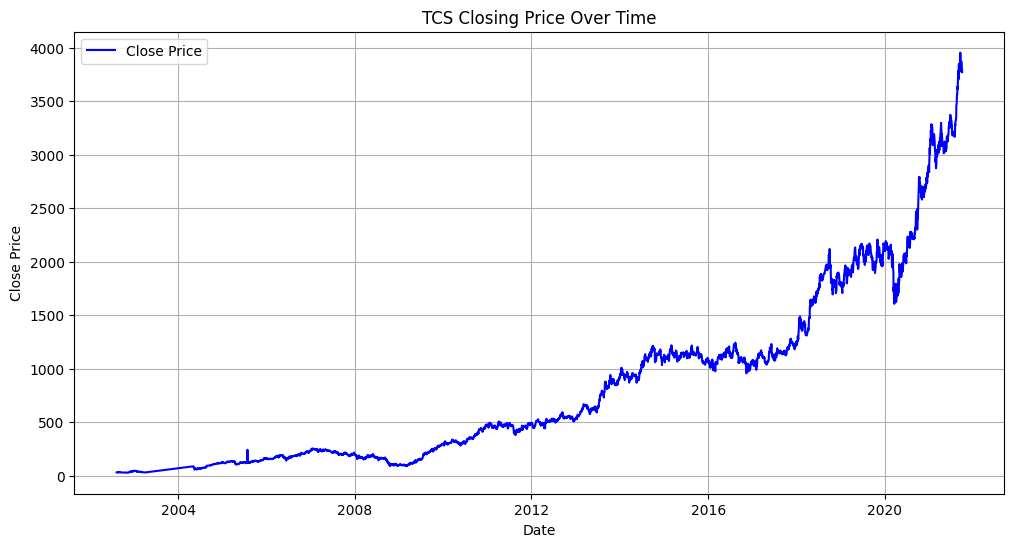

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('TCS Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


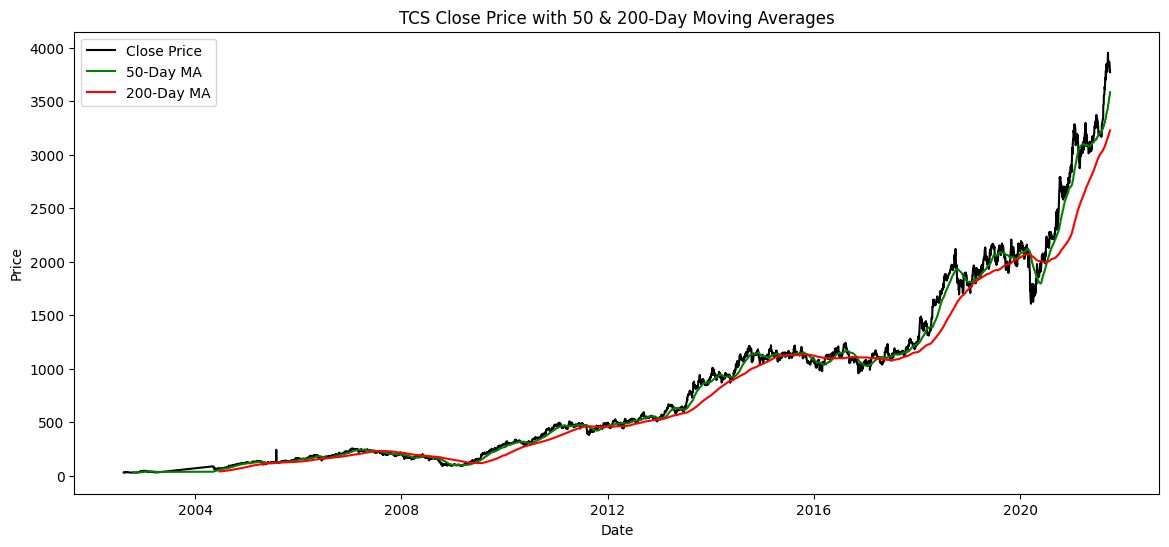

In [ ]:
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='black')
plt.plot(df['Date'], df['MA50'], label='50-Day MA', color='green')
plt.plot(df['Date'], df['MA200'], label='200-Day MA', color='red')
plt.title('TCS Close Price with 50 & 200-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
!pip install ta --quiet


In [ ]:
import ta
df = pd.read_csv("TCS_stock_history.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.reset_index(drop=True, inplace=True)


In [ ]:

df['rsi'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()
df['macd'] = ta.trend.MACD(close=df['Close']).macd()
df['bb_upper'] = ta.volatility.BollingerBands(close=df['Close']).bollinger_hband()
df['bb_lower'] = ta.volatility.BollingerBands(close=df['Close']).bollinger_lband()


In [ ]:
df['Prev_Close'] = df['Close'].shift(1)
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek


In [ ]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Prev_Close', 'rsi', 'macd', 'bb_upper', 'bb_lower', 'Day', 'Month', 'DayOfWeek']]
df.dropna(inplace=True)
print("Final shape:", df.shape)


Final shape: (4438, 13)


In [ ]:
features = ['Open', 'High', 'Low', 'Volume', 'Prev_Close', 'rsi', 'macd', 'bb_upper', 'bb_lower', 'Day', 'Month', 'DayOfWeek']
X = df[features]
y = df['Close']

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 123.97480536492154
R2 Score: 0.9998162012277275


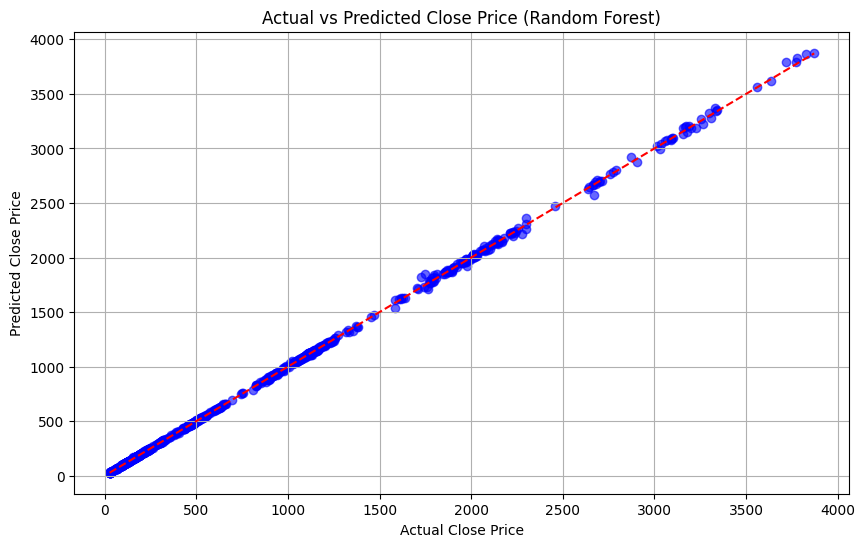

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal line
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted Close Price (Random Forest)')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

close_prices = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

sequence_length = 60
X_lstm, y_lstm = [], []

for i in range(sequence_length, len(scaled_data)):
    X_lstm.append(scaled_data[i-sequence_length:i, 0])
    y_lstm.append(scaled_data[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_lstm, y_lstm, epochs=10, batch_size=32)


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 0.0127
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 1.5187e-04
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 1.7813e-04
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 1.5910e-04
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 1.5665e-04
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 1.3033e-04
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 1.1717e-04
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 1.1252e-04
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 9.9301e-05
Epoch 10/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 1.0469e-04


In [ ]:
!pip install prophet


In [ ]:
df = pd.read_csv("TCS_stock_history.csv", parse_dates=["Date"])
df.columns = df.columns.str.strip()


In [ ]:
prophet_df = df[['Date', 'Close']].rename(columns={"Date": "ds", "Close": "y"})


DEBUG:cmdstanpy:input tempfile: /tmp/tmphrk8bz_l/qv3asdlp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphrk8bz_l/f7sb7tds.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70188', 'data', 'file=/tmp/tmphrk8bz_l/qv3asdlp.json', 'init=/tmp/tmphrk8bz_l/f7sb7tds.json', 'output', 'file=/tmp/tmphrk8bz_l/prophet_modelon5xegxt/prophet_model-20250702150512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:05:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:05:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


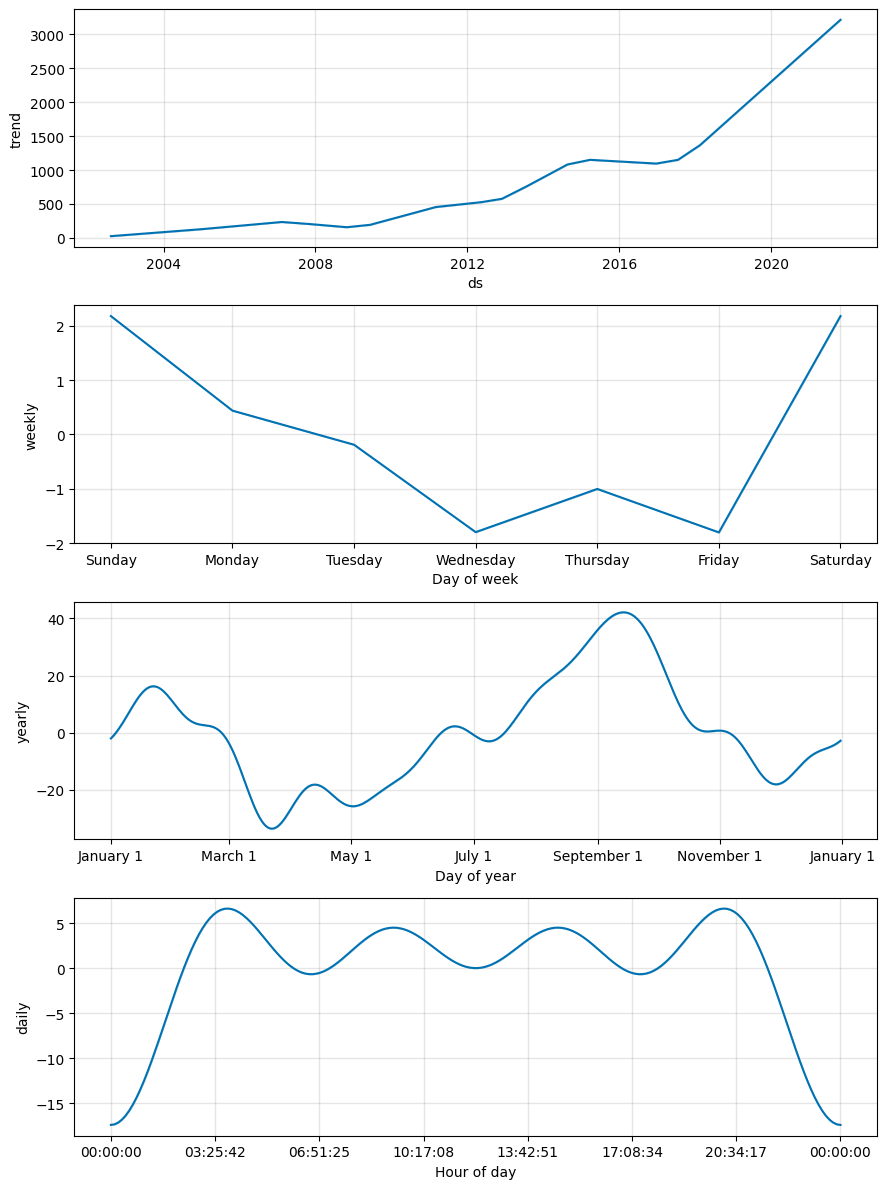

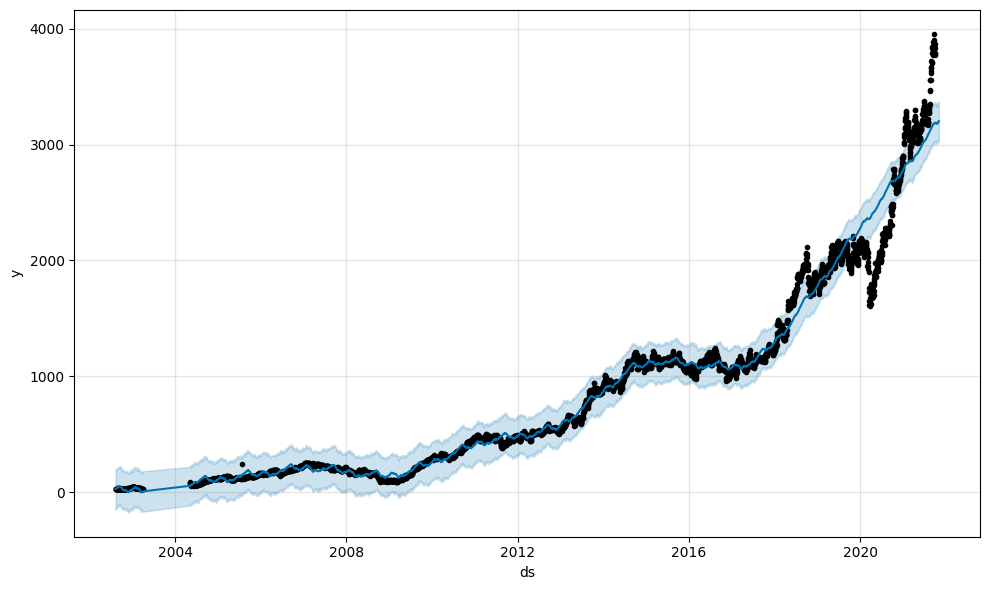

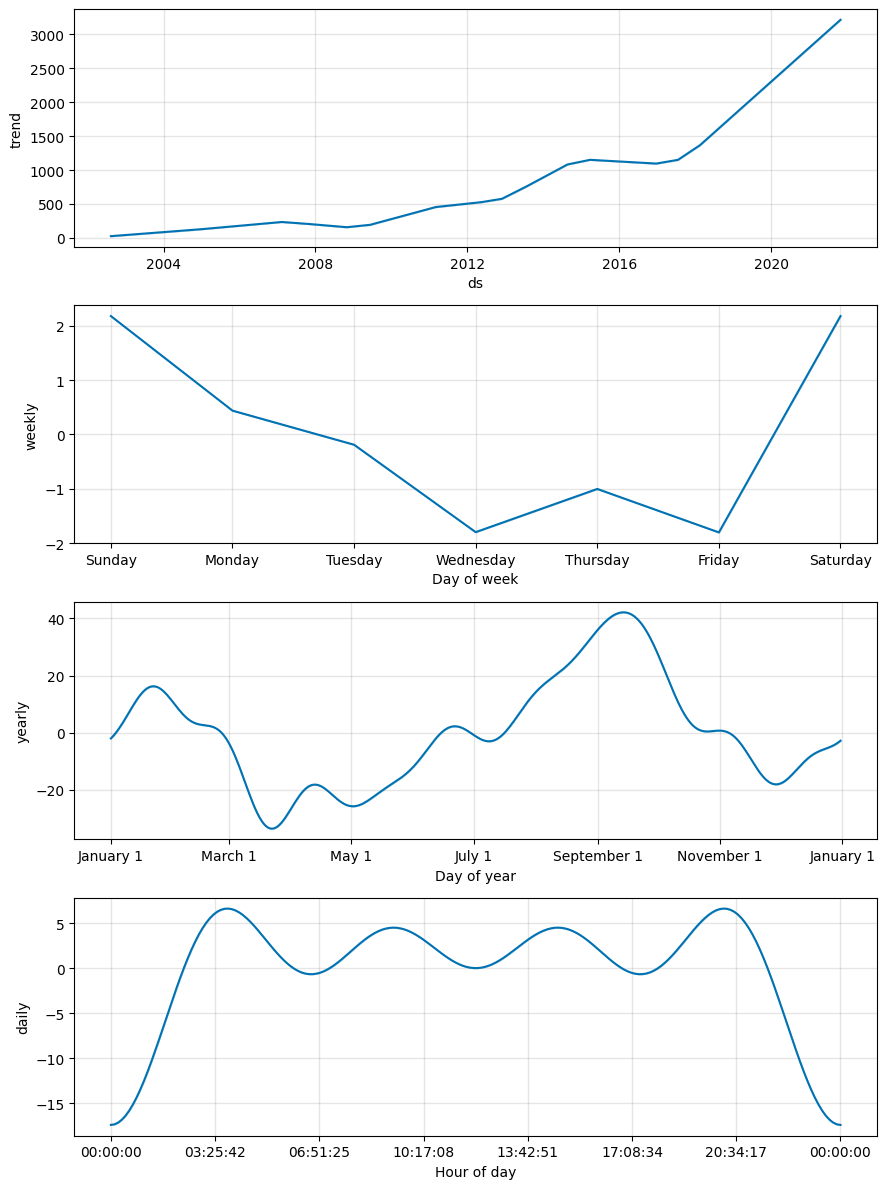

In [ ]:
from prophet import Prophet

model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

model.plot(forecast)
model.plot_components(forecast)
